## Medical Insurance Cost with Linear Regression

##### Many factors that affect how much you pay for health insurance are not within your control. Nonetheless, it's good to have an understanding of what they are. We will build a Linear regression model for Medical cost dataset. The dataset consists of age, sex, BMI(body mass index), children, smoker and region feature, which are independent and charge as a dependent feature. We will predict individual medical costs billed by health insurance.

### Which Factors Influence the Price of Health Insurance?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

### 1) Load and Inspect the Data

In [5]:
df=pd.read_csv("insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### 2) Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [9]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

<Axes: >

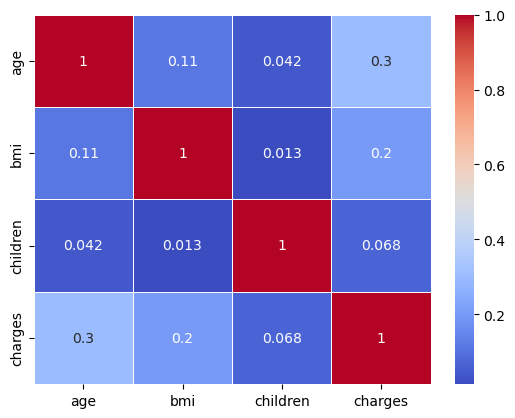

In [10]:
corr=df.corr(numeric_only=True)
sns.heatmap(corr,annot=True,cmap="coolwarm",linewidth=0.5)

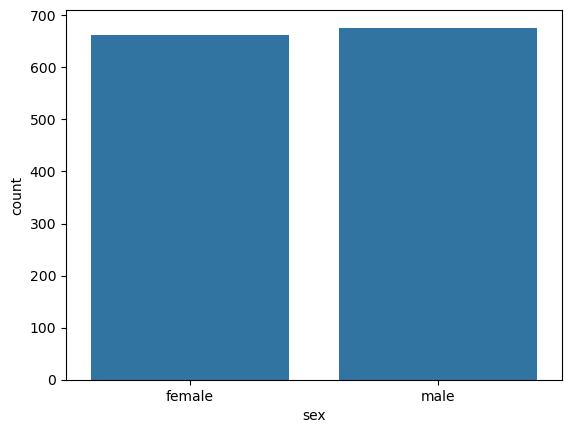

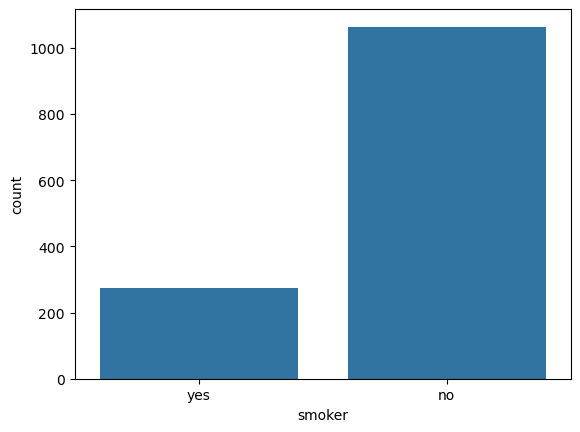

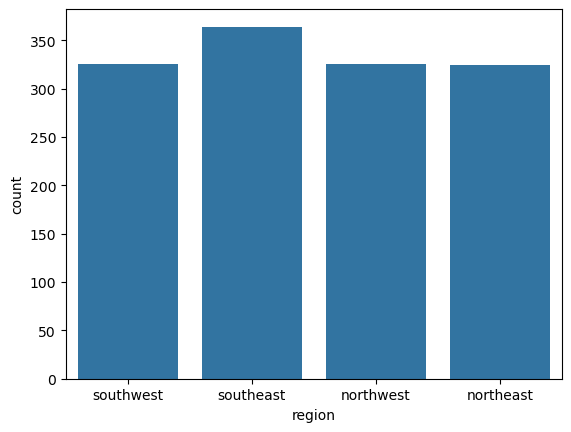

In [11]:
for col in ['sex', 'smoker', 'region']:
    sns.countplot(x=col, data=df)
    plt.show()

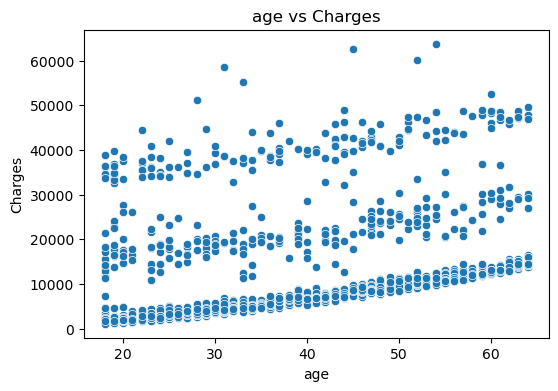

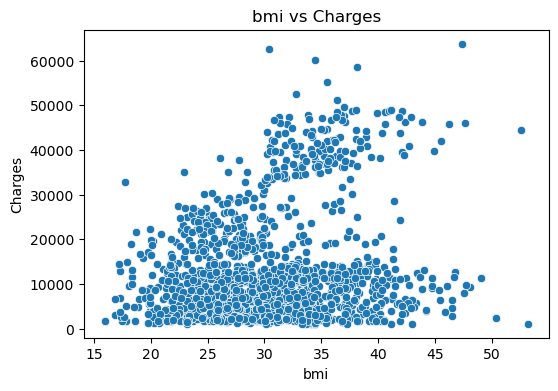

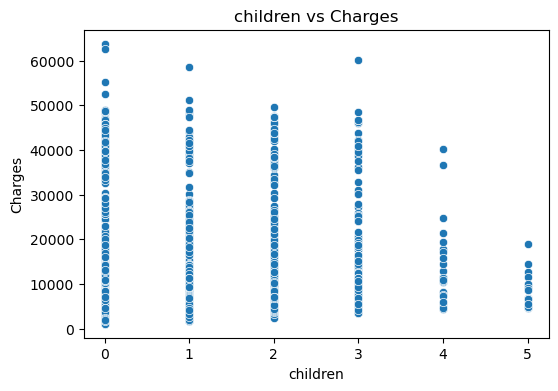

In [12]:
numerical_features = ['age', 'bmi', 'children']

for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df, x=feature, y='charges')
    plt.title(f'{feature} vs Charges')
    plt.xlabel(feature)
    plt.ylabel('Charges')
    plt.show()

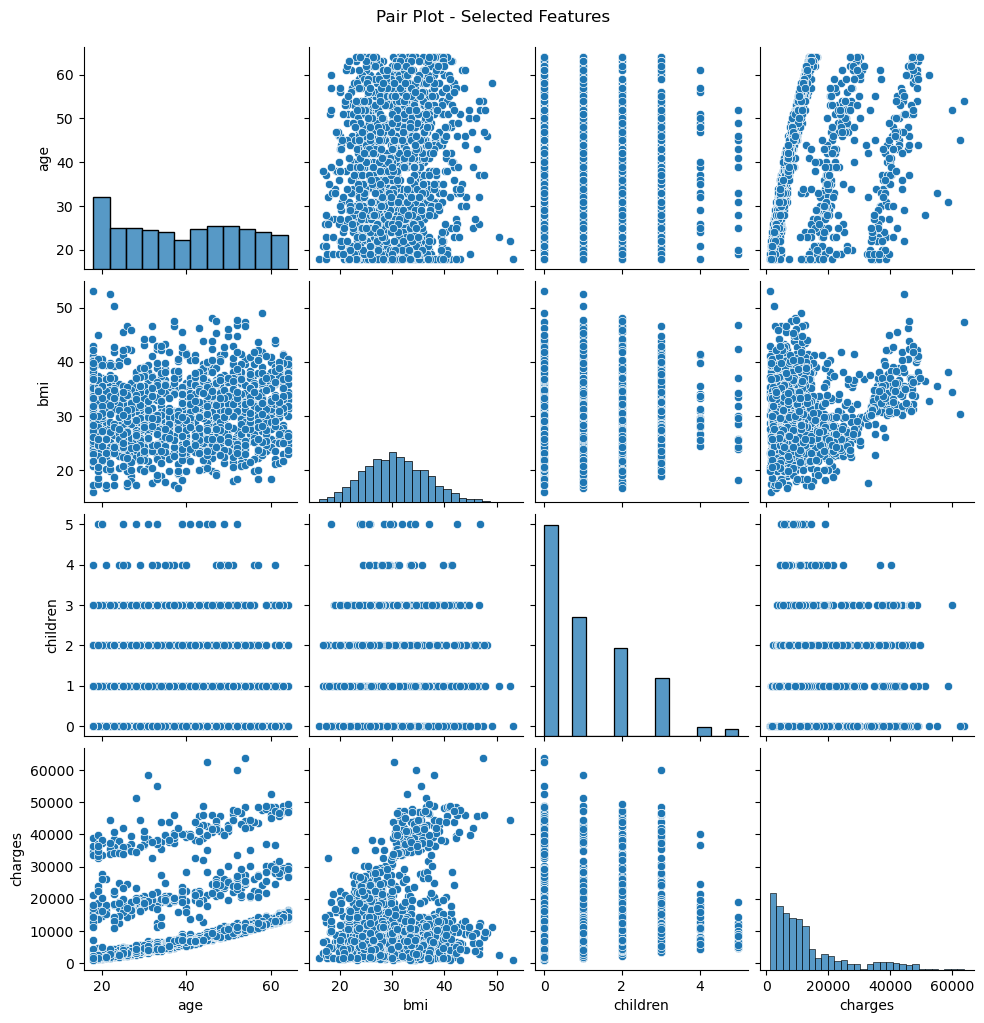

In [13]:
sns.pairplot(df[['age', 'bmi', 'children', 'charges']])
plt.suptitle("Pair Plot - Selected Features", y=1.02)
plt.show()

In [14]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### 3) Data Preprocessing (Encoding Categorical Variables)

In [16]:
df_encoded=pd.get_dummies(df,drop_first=True,dtype=int)
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


### Normalization:

In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_encoded['charges_normalized'] = scaler.fit_transform(df[['charges']])

In [19]:
print(df_encoded[['charges', 'charges_normalized']].head())

       charges  charges_normalized
0  16884.92400            0.251611
1   1725.55230            0.009636
2   4449.46200            0.053115
3  21984.47061            0.333010
4   3866.85520            0.043816


### 4) Feature Selection + Train-Test Split

In [21]:
X=df_encoded.drop(["charges","charges_normalized"],axis=1)
y=df_encoded["charges_normalized"]

In [22]:
y

0       0.251611
1       0.009636
2       0.053115
3       0.333010
4       0.043816
          ...   
1333    0.151299
1334    0.017305
1335    0.008108
1336    0.014144
1337    0.447249
Name: charges_normalized, Length: 1338, dtype: float64

In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Forward feature selection to find best features

In [25]:
# Forward Selection feature
def forward_feature_selection(X,y,significance_level=0.05):

    selected_features=[]
    remaining_features=list(X.columns)
    
    while remaining_features:
        p_values={}
        for feature in remaining_features:
            # Add the feature to the current model
            current_features=selected_features+ [feature]
            X_model=sm.add_constant(X[current_features]) # add constant for intercept
            model=sm.OLS(y,X_model).fit() # fit ols model
            p_values[feature]=model.pvalues[feature] # get the p value for the feature

        # Find the feature with the smallest p value
        best_feature=min(p_values,key=p_values.get)
        min_p_value=p_values[best_feature]

        # check if the p value is below threshold
        if min_p_value < significance_level:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"Selected Feature: {best_feature}, p_value: {min_p_value: 4f}")
        else:
            break # stop if the feature meets the significant level
    return selected_features
            

In [26]:
# Perform Forward selection on training data
print("Performing Final Selected")
selected_features=forward_feature_selection(X_train,y_train)

# Output Selected features
print("\nFinal Selected Features:",selected_features)

Performing Final Selected
Selected Feature: smoker_yes, p_value:  0.000000
Selected Feature: age, p_value:  0.000000
Selected Feature: bmi, p_value:  0.000000
Selected Feature: children, p_value:  0.005772

Final Selected Features: ['smoker_yes', 'age', 'bmi', 'children']


In [27]:
df_encoded[['smoker_yes', 'age', 'bmi', 'children']].corrwith(df_encoded['charges'])

smoker_yes    0.787251
age           0.299008
bmi           0.198341
children      0.067998
dtype: float64

<Axes: >

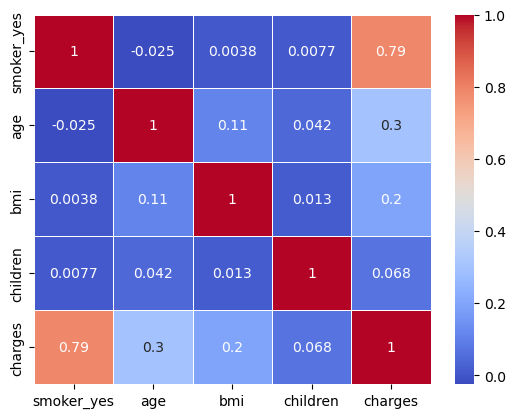

In [28]:
corr = df_encoded[['smoker_yes', 'age', 'bmi', 'children', 'charges']].corr()
sns.heatmap(corr,annot=True,cmap="coolwarm",linewidth=0.5)

### 5) Model Selection:

### A) Train the Linear Regression

In [31]:
X=df_encoded[["smoker_yes","age","bmi","children"]]
y=df_encoded["charges"]

In [32]:
X.columns

Index(['smoker_yes', 'age', 'bmi', 'children'], dtype='object')

In [33]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [34]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Evaluate the Model

In [36]:
from sklearn.metrics import r2_score, mean_absolute_error
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: ₹{mae:.2f}")

R² Score: 0.7811
Mean Absolute Error: ₹4213.80


### Prediction: 

In [38]:

custom_input = pd.DataFrame([{
    'smoker_yes': 1,
    'age': 45,
    'bmi': 27.5,
    'children': 2
}])

# Predict
prediction = model.predict(custom_input)
print(" Predicted Insurance Charges: ₹", round(prediction[0], 2))

 Predicted Insurance Charges: ₹ 32965.61


### Actual vs Predicted Plot

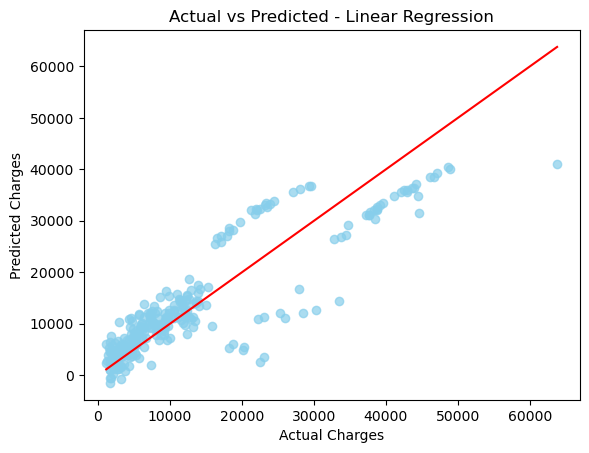

In [40]:
plt.scatter(y_test, y_pred, alpha=0.7, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title("Actual vs Predicted - Linear Regression")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.show()

#### * As we can see data is linear initially, but their is huge gap between Actual and predicted value in high charges.

### Checking Linearity: residual plot

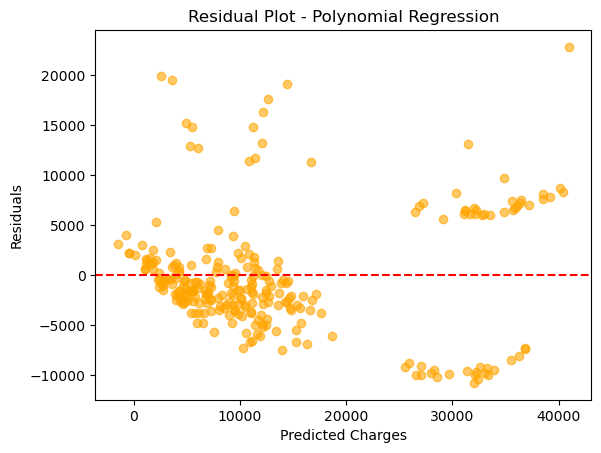

In [43]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.scatter(y_pred, residuals, color='orange', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Polynomial Regression")
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.show()

#### * We can residual are not spread and the variance of error is not constant. It is showing low Linearity, so we will try Polynomial Regression

### Checking Normality of residuals: Histogram plot

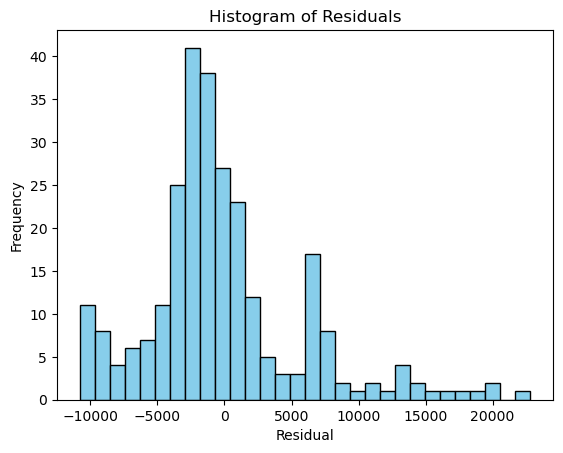

In [46]:
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

### B) Train the Polynomial Regression Model

In [48]:
X_train.columns

Index(['smoker_yes', 'age', 'bmi', 'children'], dtype='object')

In [49]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
model_poly = LinearRegression()
model_poly.fit(X_poly, y_train)
X_test_poly = poly.transform(X_test)
y_pred_poly = model_poly.predict(X_test_poly)

### 6)  Evaluate the Model

In [51]:
from sklearn.metrics import r2_score,mean_absolute_error

r2=r2_score(y_test,y_pred_poly)
mae=mean_absolute_error(y_test,y_pred_poly)
print(f"R2 Score: {r2:.4f}")
print(f"Mean Absolute error: {mae: .2f}")

R2 Score: 0.8670
Mean Absolute error:  2773.57


### * By using Polynomial regression our model is more accurate

### Actual vs Predicted Plot

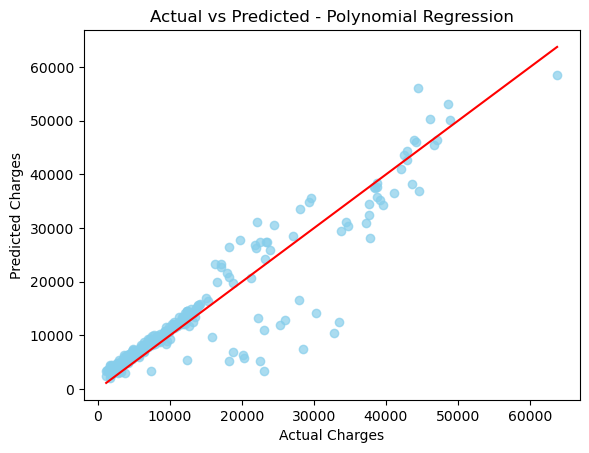

In [54]:
plt.scatter(y_test, y_pred_poly, alpha=0.7, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')
plt.title("Actual vs Predicted - Polynomial Regression")
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.show()

### Checking Linearity: residual plot

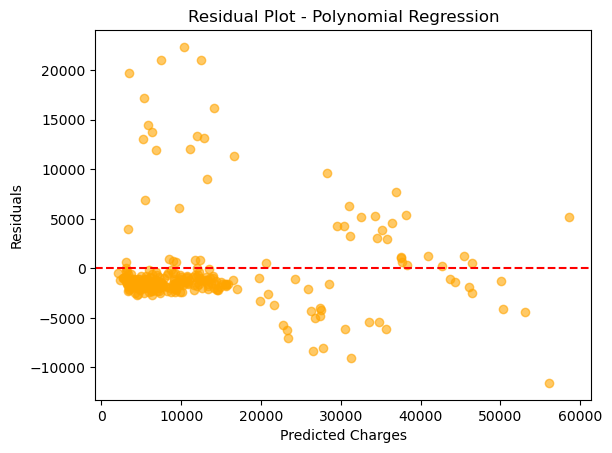

In [56]:
import matplotlib.pyplot as plt

residuals_poly = y_test - y_pred_poly

plt.scatter(y_pred_poly, residuals_poly, color='orange', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot - Polynomial Regression")
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals")
plt.show()

### Checking Normality of residuals: Histogram plot

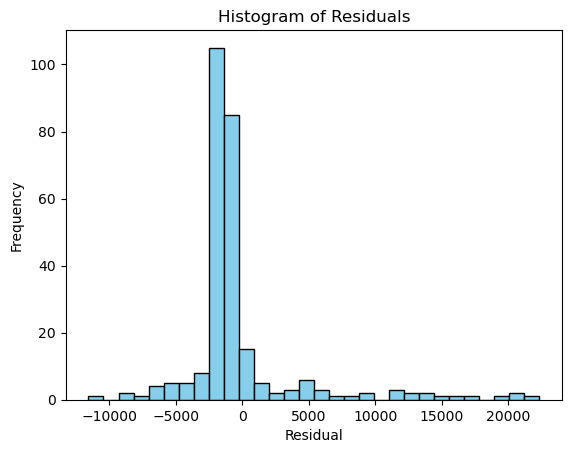

In [58]:
plt.hist(residuals_poly, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

### 7) Prediction: 

In [60]:

custom_input = pd.DataFrame([{
    'smoker_yes': 1,
    'age': 45,
    'bmi': 27.5,
    'children': 2
}])

custom_poly = poly.transform(custom_input)

# Predict
prediction = model_poly.predict(custom_poly)
print(" Predicted Insurance Charges: ₹", round(prediction[0], 2))

 Predicted Insurance Charges: ₹ 29154.21


### Conclusion:

##### Like we previously noticed smoking is the greatest factor that affects medical cost charges, then it's bmi and age. Polynomial Regression turned out to be the best model